<a href="https://colab.research.google.com/github/egorneo/Course-work/blob/main/PointCloud_tda_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes


In [ ]:
# Num points ~ accuracy(prob); different params +
# +Change intervals of parameters
# distriution

# Torus equation - ? + Magnitude of a,b,c and MSE
# Existance of eq



# TDA
# Good triangulation
# 2 ord points.=> equation

# Probability
#
# Noise (TRY) - done
#
# Genus >=2
#
# Skewed
# Non-symmetric

#18.10
#English presentation
#Test on noisy data/Train on noisy data(different ones) [different distributions]
#latex

#formulation
#Fixed surface
#Noise
#Random numbers
#Check if parameter distribution is fair
#Check cited by
#Talk on seminar
#

#10-15 ref
#



In [ ]:
#
#
#
#

In [ ]:
# y^2 = P(x), y=a+ib, x = c+i*d
# x in a cell

In [ ]:
# Hyperelliptic curve draw genus g?

## Experiments tracking setup


In [3]:
#After installing this, runtime should be restarted
!pip install numpy==1.26 > /dev/null 2>&1
!python -m pip install -U giotto-tda > /dev/null 2>&1
!pip install wandb -qU > /dev/null 2>&1

^C
^C


In [1]:
#If everything's fine, this cell should execute without errors
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import (
    Scaler,
    PersistenceEntropy,
    PersistenceLandscape,
    Amplitude,
)

In [2]:
# Log in to your W&B account
import wandb
import random
import math

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: egor-novgorodov to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports


In [16]:
import numpy as np
import math
import random
import os
import torch
import shutil
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import plotly.graph_objects as go
import plotly.express as px


random.seed = 42

## Double Torus


In [ ]:
import numpy as np
def visualize(pointcloud):
  fig = px.scatter_3d(x=pointcloud[:,0] ,y=pointcloud[:,1],z=pointcloud[:,2])
  fig.update_traces(marker=dict(size=3)) # Adjust the 'size' parameter as needed
  fig.show()

def implicit_genus2(x, y, z):
    return (x**2 + y**2 + z**2)**2 + 45*(z**4 - x**2*y**2) - 1

def sample_implicit(n_points, bounds=(-2,2), tol=0.1):
    points = []
    while len(points) < n_points:
        candidate = np.random.uniform(bounds[0], bounds[1], 3)
        if abs(implicit_genus2(*candidate)) < tol:
            points.append(candidate)
    return np.array(points)


# Generate 10,000 points
points = sample_implicit(10_000)
visualize(points)

## Generation

In [17]:
def generate_sphere_coords(N, a=1, b=4):
    u = np.random.uniform(0, 2*np.pi, N) #Not random?
    v = np.random.uniform(0, np.pi, N)

    (a,b,c) = (np.random.uniform(a,b),np.random.uniform(a,b),1)

    x = a*np.cos(u)*np.sin(v)
    y = b*np.sin(u)*np.sin(v)
    z = c*np.cos(v)

    x = np.reshape(x, (1,-1))
    y = np.reshape(y, (1,-1))
    z = np.reshape(z, (1,-1))
    coords = np.concatenate([x,y,z],axis=0).T
    return coords

def generate_torus_coords(N, a=1, b=4):
    u = np.random.uniform(0,2*np.pi,N)
    v = np.random.uniform(0,2*np.pi,N)

    c, a = (np.random.uniform(a,b), 1)

    x = (c + a * np.cos(v)) * np.cos(u)
    y = (c + a * np.cos(v)) * np.sin(u)
    z = a * np.sin(v)

    x = np.reshape(x, (1,-1))
    y = np.reshape(y, (1,-1))
    z = np.reshape(z, (1,-1))
    coords = np.concatenate([x,y,z],axis=0).T
    return coords

def gen_callback_ab(gen_func, a, b):
  return (lambda N: gen_func(N, a, b))

def generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='train'):
    '''
      N = 300 number of points in a cloud
      n = 100 number of instances
    '''
    dir = './dataset'

    if not os.path.isdir(dir):
        os.mkdir(dir)

    dir = os.path.join(dir, split)
    if not os.path.isdir(dir):
        os.mkdir(dir)
    if force_generation and os.path.isdir(os.path.join(dir,class_name)):
        shutil.rmtree(os.path.join(dir, class_name))

    working_dir = os.path.join(dir, class_name)
    if os.path.isdir(working_dir):
        print('{class_name} already generated')
    else:
        os.mkdir(working_dir)
        for i in range(n):
            coords = gen_func(N)
            np.savetxt(os.path.join(working_dir ,f'{i}'), coords)

def generate_save_all():
    generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='train')
    generate_save(N=300, n=100, gen_func=generate_sphere_coords, class_name='spheres', force_generation=True, split='test')
    generate_save(N=300, n=100, gen_func=generate_torus_coords, class_name='tori', force_generation=True, split='train')
    generate_save(N=300, n=100, gen_func=generate_torus_coords, class_name='tori', force_generation=True, split='test')


In [18]:
generate_save_all()

## Transforms

### Normalize

In [19]:
def normalize_tensorify(pointcloud, noise = 0):
  assert len(pointcloud.shape)==2
  norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
  norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
  norm_pointcloud += np.random.normal(0, noise, np.shape(norm_pointcloud))

  return  torch.tensor(norm_pointcloud)


### Unit sphere visualization

In [8]:
def visualize(pointcloud):
  fig = px.scatter_3d(x=pointcloud[:,0] ,y=pointcloud[:,1],z=pointcloud[:,2])
  fig.update_traces(marker=dict(size=3)) # Adjust the 'size' parameter as needed
  fig.show()

pointcloud = np.loadtxt('./dataset/test/tori/19')
norm_pointcloud = normalize_tensorify(pointcloud, noise=0.05)

visualize(norm_pointcloud)

## Dataset

In [28]:
class PointCloudData(Dataset):
    def __init__(self, root_dir='./dataset', folder="train", transform=normalize_tensorify, noise=0.03, outliers_percentage=0):
        self.root_dir = root_dir
        split_dir = os.path.join(root_dir, folder)

        folders = [dir for dir in sorted(os.listdir(split_dir))]

        self.classes = {folder: i for i, folder in enumerate(folders)}
        #TODO Развязать зависимость от normalize_tensorify
        self.transforms = lambda x: transform(x, noise)
        self.outliers_percentage = outliers_percentage

        self.files = []
        for category in self.classes.keys():
            cat_dir = os.path.join(split_dir, category)
            for file in os.listdir(cat_dir):
                sample = {}
                sample['pcd_path'] = os.path.join(cat_dir, file)
                sample['category'] = category
                self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        coords = np.loadtxt(file)
        if self.transforms:
            pointcloud = self.transforms(coords)
        if self.outliers_percentage > 0:
            num_outliers = int(self.outliers_percentage * len(pointcloud))
            outlier_indices = np.random.choice(len(pointcloud), num_outliers, replace=False)
            pointcloud[outlier_indices] = torch.tensor(np.random.uniform(-1, 1, (num_outliers, 3)))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

In [37]:
import torch
from torch.utils.data import Dataset
import numpy as np

class TDAWrappedDataset(Dataset):
    def __init__(self, base_dataset, tda_pipeline, fit_pipeline=False):
        """
        base_dataset: original dataset with 'pointcloud' and 'category' keys
        tda_pipeline: your scikit-tda pipeline
        fit_pipeline: if True, fits the TDA pipeline on the whole dataset
        """
        self.base_dataset = base_dataset
        self.tda_pipeline = tda_pipeline

        # Extract all pointclouds
        pointclouds = [item['pointcloud'] for item in base_dataset]
        pointclouds_np = np.stack(pointclouds, axis=0)

        # Fit TDA pipeline if needed
        if fit_pipeline:
            self.tda_features = tda_pipeline.fit_transform(pointclouds_np)
        else:
            self.tda_features = tda_pipeline.transform(pointclouds_np)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        item = self.base_dataset[idx]
        tda_feat = self.tda_features[idx]
        return {
            'pointcloud': torch.tensor(item['pointcloud'], dtype=torch.float32),
            'category': torch.tensor(item['category'], dtype=torch.long),
            'tda_features': torch.tensor(tda_feat, dtype=torch.float32)
        }


In [38]:
# inv_classes = {i: cat for cat, i in train_ds.classes.items()};
# inv_classes
# print('Train dataset size: ', len(train_ds))
# print('Valid dataset size: ', len(valid_ds))
# print('Number of classes: ', len(train_ds.classes))
# print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
# print('Class: ', inv_classes[train_ds[0]['category']])

{0: 'spheres', 1: 'tori'}

In [36]:
train_ds = PointCloudData(folder='train', outliers_percentage=0.1)
valid_ds = PointCloudData(folder='test', outliers_percentage=0.1)

In [39]:
train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64, shuffle=True)

Automated dataset generation


In [40]:
def generate_loaders(N = 300, n = 100, FORCE_GENERATION = False):
    main(N,n , FORCE_GENERATION, 'train')
    main(N, n, FORCE_GENERATION, 'test')
    train_ds = PointCloudData(folder='train')
    valid_ds = PointCloudData(folder='test')
    train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=64, shuffle=True)

## Model

In [41]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [42]:
tda_pipeline = Pipeline([
    ("vietoris_rips", VietorisRipsPersistence(
        homology_dimensions=[0, 1],
        metric="euclidean",
        n_jobs=-1,
    )),
    ("scaler", Scaler()),
    ("features", FeatureUnion([
        ("entropy", PersistenceEntropy()),  # already 2D

        # ("landscape", Pipeline([
        #     ("land", PersistenceLandscape(n_layers=5, n_bins=50)),
        #     ("flatten", FunctionTransformer(lambda x: x.reshape(x.shape[0], -1))),
        # ])),

        ("amplitude", Pipeline([
            ("amp", Amplitude(metric="landscape")),
            ("flatten", FunctionTransformer(lambda x: x.reshape(x.shape[0], -1))),
        ]))
    ]))
])

In [43]:
X_raw = train_ds[1]['pointcloud']
X = X_raw.reshape(1, *X_raw.shape)


# Transform your point cloud into a feature vector
tda_features = tda_pipeline.fit_transform(X)
print("TDA feature vector shape:", tda_features.shape)



TDA feature vector shape: (1, 4)


## Original model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      '''k: dimensionality'''
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
  def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

  def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
pointnet = PointNet().to(device)

cpu


## Modification


In [ ]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, input):
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = pool.view(bs, -1)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        init = torch.eye(self.k, requires_grad=True).repeat(bs, 1, 1).to(input.device)
        matrix = self.fc3(xb).view(-1, self.k, self.k) + init
        return matrix

class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1, 2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1, 2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = xb.view(xb.size(0), -1)
        return output, matrix3x3, matrix64x64

class PointNetTda(nn.Module):
    def __init__(self, tda_dim, num_classes=2):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256 + tda_dim, num_classes)

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input, tda_features):
        # input: (bs, n, 3)
        # tda_features: (bs, tda_dim)
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))

        # Ensure tda_features is a torch.Tensor on the correct device
        if not isinstance(tda_features, torch.Tensor):
            tda_features = torch.tensor(tda_features, dtype=xb.dtype, device=xb.device)
        else:
            tda_features = tda_features.to(xb.device)

        xb = torch.cat([xb, tda_features], dim=1)
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64


NameError: name 'nn' is not defined

## Better modification

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TNet(nn.Module):
    def __init__(self, k: int = 3):
        super().__init__()
        self.k = k
        self.conv = nn.Sequential(
            nn.Conv1d(k, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Conv1d(128, 1024, 1),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, k * k)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv(x)
        x = torch.max(x, dim=2)[0]  # Global max pooling
        x = self.fc(x)

        identity = torch.eye(self.k, device=x.device).unsqueeze(0).repeat(batch_size, 1, 1)
        x = x.view(-1, self.k, self.k) + identity
        return x


class PointNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = TNet(k=3)
        self.feature_transform = TNet(k=64)

        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, x):
        matrix3x3 = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), matrix3x3).transpose(1, 2)

        x = F.relu(self.bn1(self.conv1(x)))

        matrix64x64 = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), matrix64x64).transpose(1, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, dim=2)[0]  # Global max pooling
        return x, matrix3x3, matrix64x64


class PointNetWithTDA(nn.Module):
    def __init__(self, tda_feature_dim: int, num_classes: int = 2):
        super().__init__()
        self.encoder = PointNetEncoder()

        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 + tda_feature_dim, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, points, tda_features):
        x, matrix3x3, matrix64x64 = self.encoder(points)

        x = self.mlp(x)

        if not isinstance(tda_features, torch.Tensor):
            tda_features = torch.tensor(tda_features, dtype=x.dtype, device=x.device)
        else:
            tda_features = tda_features.to(x.device)

        x = torch.cat([x, tda_features], dim=1)
        out = self.classifier(x)

        return out, matrix3x3, matrix64x64


## Better baseline

In [46]:
class PointNetBaseline(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.encoder = PointNetEncoder()
        self.mlp = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, points):
        x, matrix3x3, matrix64x64 = self.encoder(points)
        x = self.mlp(x)
        out = self.classifier(x)
        return out, matrix3x3, matrix64x64


In [47]:

# for x in train_loader:
#   X_batch = x['pointcloud']
#   break

# # Assume: batch of point clouds of shape (bs, n_points, 3)
# pointcloud_tensor = torch.tensor(X_batch, dtype=torch.float32)  # shape: (bs, n, 3)

# # Assume: tda_features is already precomputed using your pipeline
# tda_features = tda_pipeline.fit_transform(X_batch)  # shape: (bs, tda_dim)

# # Create the model
# tda_dim = tda_features.shape[1]
# model = PointNet(tda_dim=tda_dim, num_classes=2)

# print(pointcloud_tensor.shape)
# print(tda_features.shape)
# # Forward pass
# log_probs, mat3x3, mat64x64 = model(pointcloud_tensor.transpose(1, 2), tda_features)


## Training loop

In [48]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if 1:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
    if save:
        torch.save(pointnet.state_dict(), "model.pth")

NameError: name 'pointnet' is not defined

In [49]:
# New version
def train_tda(model, train_loader, val_loader=None, epochs=15, save=True, device='cpu'):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs = data['pointcloud'].to(device).float()
            labels = data['category'].to(device)
            tda_features = data['tda_features'].to(device).float()

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2), tda_features)
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if 1:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        model.eval()
        correct = total = 0
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs = data['pointcloud'].to(device).float()
                    labels = data['category'].to(device)
                    tda_features = data['tda_features'].to(device).float()

                    outputs, _, _ = model(inputs.transpose(1, 2), tda_features)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

    if save:
        torch.save(model.state_dict(), "model.pth")



In [50]:
# Wrap your dataset
train_dataset_wrapped = TDAWrappedDataset(train_ds, tda_pipeline, fit_pipeline=True)
val_dataset_wrapped = TDAWrappedDataset(valid_ds, tda_pipeline, fit_pipeline=False)

train_loader_wrapped = torch.utils.data.DataLoader(train_dataset_wrapped, batch_size=64, shuffle=True)
val_loader_wrapped = torch.utils.data.DataLoader(val_dataset_wrapped, batch_size=64)


In [ ]:
#old setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# pointnet = PointNet()
# pointnet.to(device)
train(pointnet, train_loader, valid_loader,  save=True)

[Epoch: 1, Batch:    1 /    4], loss: 0.077
[Epoch: 1, Batch:    2 /    4], loss: 0.073
[Epoch: 1, Batch:    3 /    4], loss: 0.074
[Epoch: 1, Batch:    4 /    4], loss: 0.078
Valid accuracy: 57 %
[Epoch: 2, Batch:    1 /    4], loss: 0.078
[Epoch: 2, Batch:    2 /    4], loss: 0.077
[Epoch: 2, Batch:    3 /    4], loss: 0.071
[Epoch: 2, Batch:    4 /    4], loss: 0.063
Valid accuracy: 54 %
[Epoch: 3, Batch:    1 /    4], loss: 0.071
[Epoch: 3, Batch:    2 /    4], loss: 0.076
[Epoch: 3, Batch:    3 /    4], loss: 0.075
[Epoch: 3, Batch:    4 /    4], loss: 0.075
Valid accuracy: 55 %
[Epoch: 4, Batch:    1 /    4], loss: 0.072
[Epoch: 4, Batch:    2 /    4], loss: 0.077
[Epoch: 4, Batch:    3 /    4], loss: 0.079
[Epoch: 4, Batch:    4 /    4], loss: 0.063
Valid accuracy: 54 %
[Epoch: 5, Batch:    1 /    4], loss: 0.071
[Epoch: 5, Batch:    2 /    4], loss: 0.074
[Epoch: 5, Batch:    3 /    4], loss: 0.080
[Epoch: 5, Batch:    4 /    4], loss: 0.059
Valid accuracy: 51 %
[Epoch: 6, Batc

In [ ]:
#TODO reset parameters function
#generate_loaders(300,100,True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
pointnet = PointNetWithTDA(tda_feature_dim=4)
pointnet.to(device)
train_tda(pointnet, train_loader_wrapped, val_loader_wrapped, epochs=15, save=True, device=device)
#train(pointnet, train_loader, valid_loader,  save=True)

<ipython-input-25-46548a3eeed6>:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



NameError: name 'optimizer' is not defined

In [ ]:
def train_baseline(model, train_loader, val_loader=None, epochs=15, save=True, device='cpu'):
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            inputs = data['pointcloud'].to(device).float()
            labels = data['category'].to(device)

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct = total = 0
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs = data['pointcloud'].to(device).float()
                    labels = data['category'].to(device)
                    outputs, _, _ = model(inputs.transpose(1, 2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            print(f'[Epoch {epoch+1}] Valid accuracy: {100. * correct / total:.2f}%')

    if save:
        torch.save(model.state_dict(), "model_baseline.pth")
baseline_model = PointNetBaseline(num_classes=2).to(device)
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
train_baseline(baseline_model, train_loader_wrapped, val_loader_wrapped, epochs=15, device=device)


<ipython-input-25-46548a3eeed6>:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[Epoch 1] Valid accuracy: 50.00%
[Epoch 2] Valid accuracy: 50.00%
[Epoch 3] Valid accuracy: 41.50%
[Epoch 4] Valid accuracy: 50.00%
[Epoch 5] Valid accuracy: 50.00%
[Epoch 6] Valid accuracy: 50.00%
[Epoch 7] Valid accuracy: 50.00%
[Epoch 8] Valid accuracy: 50.00%
[Epoch 9] Valid accuracy: 48.50%
[Epoch 10] Valid accuracy: 59.00%
[Epoch 11] Valid accuracy: 86.50%
[Epoch 12] Valid accuracy: 89.50%
[Epoch 13] Valid accuracy: 99.50%
[Epoch 14] Valid accuracy: 56.50%
[Epoch 15] Valid accuracy: 100.00%


In [ ]:
def train_tda(model, train_loader, val_loader=None, epochs=15, save=True, device='cpu', lr=0.001, save_path="pointnet_tda.pth"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs = data['pointcloud'].to(device).float()             # (B, N, 3)
            labels = data['category'].to(device)                       # (B,)
            tda_features = data['tda_features'].to(device).float()     # (B, D_tda)

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2), tda_features)
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print('[Epoch %d, Batch %d/%d] loss: %.4f' %
                      (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        # Evaluate on validation set
        if val_loader:
            model.eval()
            correct = total = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs = data['pointcloud'].to(device).float()
                    labels = data['category'].to(device)
                    tda_features = data['tda_features'].to(device).float()

                    outputs, _, _ = model(inputs.transpose(1, 2), tda_features)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print(f'[Epoch {epoch+1}] Validation Accuracy: {val_acc:.2f}%')

    if save:
        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')


tda_model = PointNetWithTDA(tda_feature_dim=tda_features.shape[1], num_classes=2).to(device)
optimizer = torch.optim.Adam(tda_model.parameters(), lr=0.001)
train_tda(tda_model, train_loader_wrapped, val_loader_wrapped, epochs=15, device=device)


<ipython-input-25-46548a3eeed6>:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



[Epoch 1] Validation Accuracy: 50.00%
[Epoch 2] Validation Accuracy: 50.00%
[Epoch 3] Validation Accuracy: 50.00%
[Epoch 4] Validation Accuracy: 50.00%
[Epoch 5] Validation Accuracy: 50.00%
[Epoch 6] Validation Accuracy: 50.00%
[Epoch 7] Validation Accuracy: 50.00%
[Epoch 8] Validation Accuracy: 50.00%
[Epoch 9] Validation Accuracy: 51.00%
[Epoch 10] Validation Accuracy: 66.50%
[Epoch 11] Validation Accuracy: 97.00%
[Epoch 12] Validation Accuracy: 100.00%
[Epoch 13] Validation Accuracy: 100.00%
[Epoch 14] Validation Accuracy: 100.00%
[Epoch 15] Validation Accuracy: 99.00%
Model saved to pointnet_tda.pth


## Experiments

## Calibration

In [ ]:
#Source https://github.com/torrvision/focal_calibration/blob/475422a6754e20d25216158a874749c33e826e21/Metrics/plots.py#L59
#Modified in accordance with MIT licence
import math
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

# Some keys used for the following dictionaries
COUNT = 'count'
CONF = 'conf'
ACC = 'acc'
BIN_ACC = 'bin_acc'
BIN_CONF = 'bin_conf'


def _bin_initializer(bin_dict, num_bins=10):
    for i in range(num_bins):
        bin_dict[i][COUNT] = 0
        bin_dict[i][CONF] = 0
        bin_dict[i][ACC] = 0
        bin_dict[i][BIN_ACC] = 0
        bin_dict[i][BIN_CONF] = 0


def _populate_bins(confs, preds, labels, num_bins=10):
    bin_dict = {}
    for i in range(num_bins):
        bin_dict[i] = {}
    _bin_initializer(bin_dict, num_bins)
    num_test_samples = len(confs)

    for i in range(0, num_test_samples):
        confidence = confs[i]
        prediction = preds[i]
        label = labels[i]
        binn = int(math.ceil(((num_bins * confidence) - 1)))
        bin_dict[binn][COUNT] = bin_dict[binn][COUNT] + 1
        bin_dict[binn][CONF] = bin_dict[binn][CONF] + confidence
        bin_dict[binn][ACC] = bin_dict[binn][ACC] + \
            (1 if (label == prediction) else 0)

    for binn in range(0, num_bins):
        if (bin_dict[binn][COUNT] == 0):
            bin_dict[binn][BIN_ACC] = 0
            bin_dict[binn][BIN_CONF] = 0
        else:
            bin_dict[binn][BIN_ACC] = float(
                bin_dict[binn][ACC]) / bin_dict[binn][COUNT]
            bin_dict[binn][BIN_CONF] = bin_dict[binn][CONF] / \
                float(bin_dict[binn][COUNT])
    return bin_dict


def reliability_plot(confs, preds, labels, num_bins=15):
    '''
    Method to draw a reliability plot from a model's predictions and confidences.
    '''
    bin_dict = _populate_bins(confs, preds, labels, num_bins)
    bns = [(i / float(num_bins)) for i in range(num_bins)]
    y = []
    for i in range(num_bins):
        y.append(bin_dict[i][BIN_ACC])
    plt.figure(figsize=(10, 8))  # width:20, height:3
    plt.bar(bns, bns, align='edge', width=0.05, color='pink', label='Expected')
    plt.bar(bns, y, align='edge', width=0.05,
            color='blue', alpha=0.5, label='Actual')
    plt.ylabel('Accuracy')
    plt.xlabel('Confidence')
    plt.legend()
    plt.show()


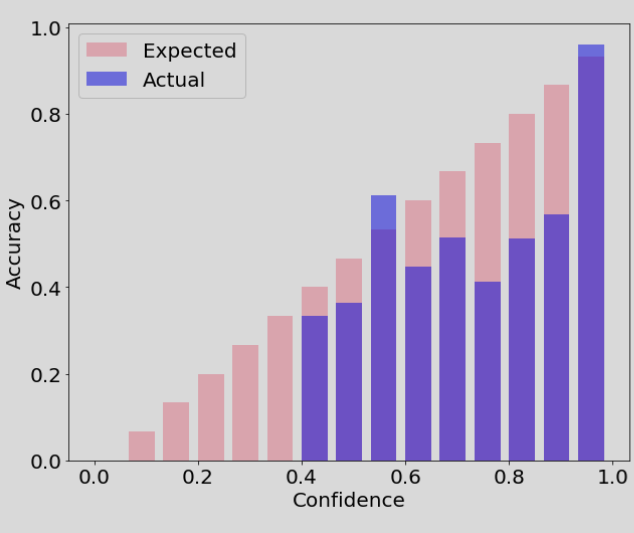

## Baseline experiment

In [ ]:
with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = model(inputs.transpose(1,2))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100. * correct / total
val_metrics = {"val_accuracy":val_acc}
wandb.log(val_metrics)

TypeError: PointNet.forward() missing 1 required positional argument: 'tda_features'

In [ ]:
# start a new wandb run to track this script
wandb.init(
    project="PCloud",
    name="Different parameter scale",
    group="Non-overlaping params",
    job_type="eval",
    # track hyperparameters
    config={
        "learning_rate": 0.001,
        "architecture": "Tnet",
        "dataset": "BaselNETine",
        "N": 100, #Points in a cloud
        "n": 100,
        "epochs": 100,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [1,4],
        "test_param_range": [5,6], #100, 150 другой масштаб; [0,1] - normalize;
        "noise": 0.07
    }
)

# Copy config
config = wandb.config

# Generate data
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['train_param_range']), class_name='spheres', force_generation=True, split='train')
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['test_param_range']), class_name='spheres', force_generation=True, split='test')
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['train_param_range']), class_name='tori', force_generation=True, split='train')
generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['test_param_range']), class_name='tori', force_generation=True, split='test')

# Create datasets
train_ds = PointCloudData(folder='train' )
valid_ds = PointCloudData(folder='test', noise=config["noise"])

# Create loaders
train_loader = DataLoader(dataset=train_ds, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=config['valid_batch_size'], shuffle=True)

# Define model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PointNet().to(device)

# Define loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
loss_func = pointnetloss

# Training

for epoch in range(config['epochs']):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        optimizer.zero_grad()
        outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

        loss = loss_func(outputs, labels, m3x3, m64x64)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        metrics = {"train/train_loss": running_loss,
                   "train/epoch": epoch,
                   "train/batch": i}
        wandb.log(metrics)


    model.eval()
    correct = total = 0

    # validation
    if valid_loader:
        with torch.no_grad():
            for data in valid_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                outputs, __, __ = model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100. * correct / total
        val_metrics = {"val_accuracy":val_acc}
        wandb.log(val_metrics)

    if train_loader:
        with torch.no_grad():
            for data in train_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                outputs, __, __ = model(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_acc = 100. * correct / total
        train_metrics = {"train_accuracy":train_acc}
        wandb.log(train_metrics)

# Save model
#torch.save(model.state_dict(), "model.pth")
#wandb.log_model("./model.pth", "point_cloud_model")

wandb.finish()

train/batch,█▁▁▆▃▃▁▃▁▆▁█▆█▃▃▆▁▁▃▁▁▁█▃▁▁▆▁▃▃▃▆▆█▁▃█▁▁
train/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
train/train_loss,█▃▂▃▄▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▃▂
train_accuracy,▁▁▁▁▆███▂▅▇▃▆███▄▂▂▃██▆▇▄▅▅▅▅▄██▇▅██▁█▆█
val_accuracy,▃▃▃▄▇████▃▁▄▄▅▄████▃▃▄▆▇▄▄▄▄▃▄████▃██▅▅▇
train/batch,3
train/epoch,99
train/train_loss,0.14084
train_accuracy,95.25
val_accuracy,90.5


## New wandb

In [51]:
def train_no_tda_wandb(model, train_loader, val_loader, optimizer, device='cpu', epochs=15):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            inputs = batch['pointcloud'].to(device).float()
            labels = batch['category'].to(device)

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2))
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        val_acc = evaluate(model, val_loader, device=device)
        wandb.log({"epoch": epoch+1, "loss": total_loss / len(train_loader), "val_acc": val_acc})


def train_tda_wandb(model, train_loader, val_loader, optimizer, device='cpu', epochs=15):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            inputs = batch['pointcloud'].to(device).float()
            tda = batch['tda_features'].to(device).float()
            labels = batch['category'].to(device)

            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1, 2), tda)
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader, device=device, use_tda=True)
        wandb.log({"epoch": epoch+1, "loss": total_loss / len(train_loader), "val_acc": val_acc})
@torch.no_grad()
def evaluate(model, loader, device='cpu', use_tda=False):
    model.eval()
    correct = total = 0
    for batch in loader:
        inputs = batch['pointcloud'].to(device).float()
        labels = batch['category'].to(device)

        if use_tda:
            tda = batch['tda_features'].to(device).float()
            outputs, _, _ = model(inputs.transpose(1, 2), tda)
        else:
            outputs, _, _ = model(inputs.transpose(1, 2))

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return 100. * correct / total


In [52]:
def create_tda_pipeline():
  tda_pipeline = Pipeline([
      ("vietoris_rips", VietorisRipsPersistence(
          homology_dimensions=[0, 1],
          metric="euclidean",
          n_jobs=-1,
      )),
      ("scaler", Scaler()),
      ("features", FeatureUnion([
          ("entropy", PersistenceEntropy()),  # already 2D

          # ("landscape", Pipeline([
          #     ("land", PersistenceLandscape(n_layers=5, n_bins=50)),
          #     ("flatten", FunctionTransformer(lambda x: x.reshape(x.shape[0], -1))),
          # ])),

          ("amplitude", Pipeline([
              ("amp", Amplitude(metric="landscape")),
              ("flatten", FunctionTransformer(lambda x: x.reshape(x.shape[0], -1))),
          ]))
      ]))
  ])
  return tda_pipeline

In [56]:
import wandb
import torch
from torch.utils.data import DataLoader
import numpy as np

# Main experiment wrapper
def run_experiment(config=None):
    with wandb.init(config=config, project="PCloud", group="Param sweep", job_type="eval") as run:
        config = wandb.config

        # Dataset generation
        generate_save(N=config.N, n=config.n,
                      gen_func=gen_callback_ab(generate_sphere_coords, *config.train_param_range),
                      class_name='spheres', force_generation=True, split='train')
        generate_save(N=config.N, n=config.n,
                      gen_func=gen_callback_ab(generate_sphere_coords, *config.test_param_range),
                      class_name='spheres', force_generation=True, split='test')

        generate_save(N=config.N, n=config.n,
                      gen_func=gen_callback_ab(generate_torus_coords, *config.train_param_range),
                      class_name='tori', force_generation=True, split='train')
        generate_save(N=config.N, n=config.n,
                      gen_func=gen_callback_ab(generate_torus_coords, *config.test_param_range),
                      class_name='tori', force_generation=True, split='test')

        # Load datasets
        train_ds = PointCloudData(folder='train', noise=config.noise, outliers_percentage=config.outliers_percentage)
        valid_ds = PointCloudData(folder='test', noise=config.noise, outliers_percentage=config.outliers_percentage)

        # TDA pipeline setup (if needed)
        if config.use_tda:
            tda_pipeline = create_tda_pipeline()  # Define this separately
            train_ds = TDAWrappedDataset(train_ds, tda_pipeline, fit_pipeline=True)
            valid_ds = TDAWrappedDataset(valid_ds, tda_pipeline, fit_pipeline=False)

        # DataLoaders
        train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle=True)
        valid_loader = DataLoader(valid_ds, batch_size=config.valid_batch_size)

        # Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Model
        if config.use_tda:
            model = PointNetWithTDA(tda_feature_dim=4, num_classes=2) #bad constant
        else:
            model = PointNetBaseline(num_classes=2)

        model.to(device)

        # Optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        # Training
        if config.use_tda:
            train_tda_wandb(model, train_loader, valid_loader, optimizer, device=device, epochs=config.epochs)
        else:
            train_no_tda_wandb(model, train_loader, valid_loader, optimizer, device=device, epochs=config.epochs)

        # Save final model
        model_path = f"{run.name}_final.pth"
        torch.save(model.state_dict(), model_path)
        wandb.save(model_path)


In [58]:
sweep_config = {
    "learning_rate": 0.0001,
    "architecture": "PointNetModified",
    "N": 100,
    "n": 100,
    "epochs": 100,
    "train_batch_size": 64,
    "valid_batch_size": 64,
    "train_param_range": [1, 8],
    "test_param_range": [10, 11],
    "noise": 0.07,
    "outliers_percentage": 0.2,
    "use_tda": False
}

run_experiment(sweep_config)


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
loss,█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▅▆▅▃▂▁▂▁▂▁
val_acc,▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▂▁▅▄▁██▇▇▇█▇█
epoch,100
loss,0.18761
val_acc,95


# Разные конфиги


In [ ]:
configs = [
    {
        "learning_rate": 0.001,
        "architecture": "Tnet",
        "use_tda": False,
        "N": 100,
        "n": 100,
        "epochs": 50,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [1, 4],
        "test_param_range": [5, 6],
        "noise": 0.07
    },
    {
        "learning_rate": 0.001,
        "architecture": "Tnet+TDA",
        "use_tda": True,
        "N": 100,
        "n": 100,
        "epochs": 50,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [1, 4],
        "test_param_range": [5, 6],
        "noise": 0.07
    },
    {
        "learning_rate": 0.001,
        "architecture": "Tnet",
        "use_tda": False,
        "N": 100,
        "n": 100,
        "epochs": 50,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [0.5, 1],
        "test_param_range": [1.5, 2],
        "noise": 0.07
    },
    {
        "learning_rate": 0.001,
        "architecture": "Tnet+TDA",
        "use_tda": True,
        "N": 100,
        "n": 100,
        "epochs": 50,
        "train_batch_size": 64,
        "valid_batch_size": 64,
        "train_param_range": [0.5, 1],
        "test_param_range": [1.5, 2],
        "noise": 0.07
    }
]

[run_experiment(configs) for config in configs]


NameError: name 'run_experiment' is not defined

In [ ]:
!pip install torch torchvision
!pip install "git+https://github.com/yanx27/Pointnet_Pointnet2_pytorch.git"


#Cycled experiments

In [ ]:
# start a new wandb run to track this script
for n in [300]:
    wandb.init(
        settings=wandb.Settings(start_method="fork"),
        project="PCloud",
        name=f"Cycle n={n}_2",
        group="Cyclic-n",
        job_type="eval",
        # track hyperparameters
        config={
            "learning_rate": 0.0001,
            "architecture": "Tnet",
            "dataset": "Baseline",
            "N": 100, # Points in a cloud
            "n": n,
            "epochs": 60,
            "train_batch_size": 64,
            "valid_batch_size": 64,
            "train_param_range": [1,3],
            "test_param_range": [1,3],
        }
    )

    # Copy config
    config = wandb.config

    # Generate data
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['train_param_range']), class_name='spheres', force_generation=True, split='train')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_sphere_coords,*config['test_param_range']), class_name='spheres', force_generation=True, split='test')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['train_param_range']), class_name='tori', force_generation=True, split='train')
    generate_save(N=config['N'], n=config['n'], gen_func=gen_callback_ab(generate_torus_coords,*config['test_param_range']), class_name='tori', force_generation=True, split='test')

    # Create datasets
    train_ds = PointCloudData(folder='train')
    valid_ds = PointCloudData(folder='test')

    # Create loaders
    train_loader = DataLoader(dataset=train_ds, batch_size=config['train_batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=config['valid_batch_size'], shuffle=True)

    # Define model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = PointNet().to(device)

    # Define loss and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss_func = pointnetloss

    # Training

    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = loss_func(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            metrics = {"train/train_loss": running_loss,
                      "train/epoch": epoch,
                      "train/batch": i}
            wandb.log(metrics)


        model.eval()
        correct = 0
        total = 0

        # validation
        if valid_loader:
            with torch.no_grad():
                for data in valid_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            val_metrics = {"val_accuracy":val_acc}
            wandb.log(val_metrics)

    # Save model
    #torch.save(model.state_dict(), "model.pth")
    wandb.log_model("./model.pth", "point_cloud_model")

    wandb.finish()

train/batch,▆▃█▁▁▂▆▁▆▃▃█▁▃▅▁▃▃▅▄▇▃▂█▇▅▃▁▃▆▆▅▆██▃▇▂▃▆
train/epoch,▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
train/train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▆▇███▄████████████████████████████████
train/batch,9
train/epoch,59
train/train_loss,0.03063
val_accuracy,100


## Test

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pointnet = PointNet()
pointnet.load_state_dict(torch.load('model.pth'))
pointnet.eval();

In [ ]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())



Batch [   1 /    5]
Batch [   2 /    5]
Batch [   3 /    5]
Batch [   4 /    5]
Batch [   5 /    5]


In [ ]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[140,  10],
       [  2, 148]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


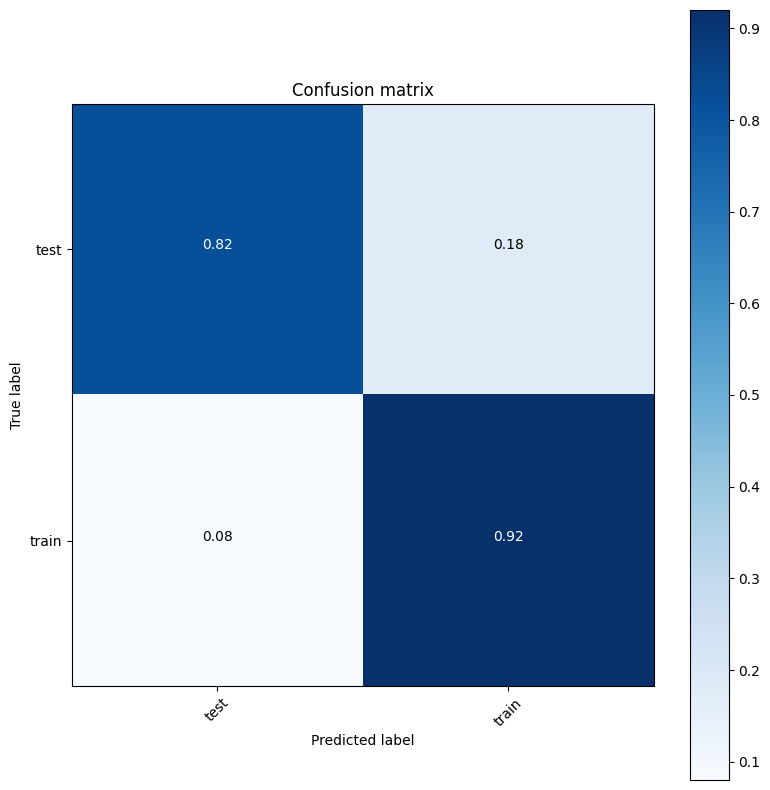

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


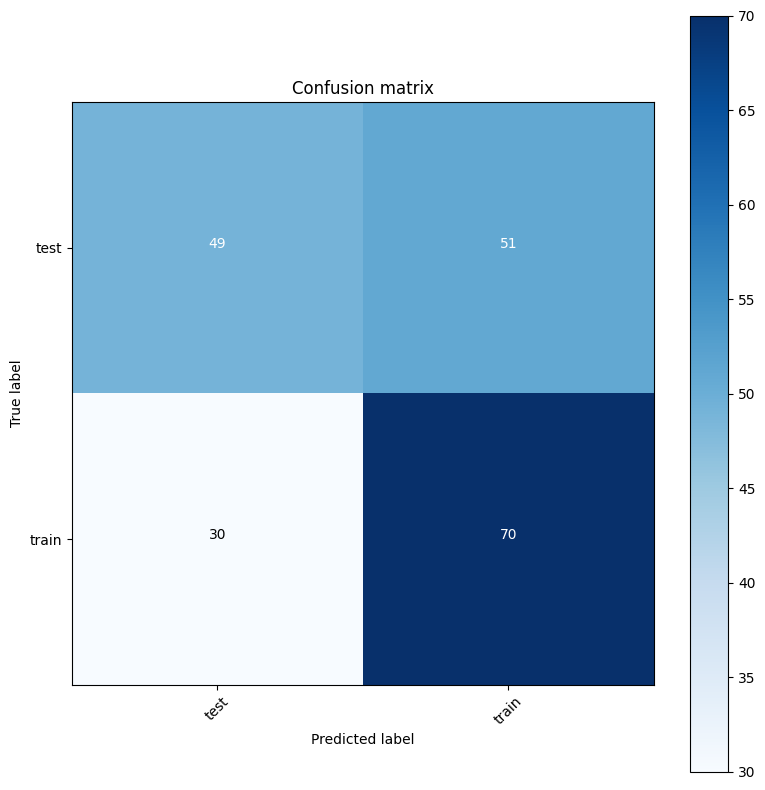

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

# Experimenting with T-NET


In [ ]:
from scipy.stats import ortho_group
mat = torch.tensor(ortho_group.rvs(dim=3))
torch.matmul(mat,mat.T)
j=400
pc_test = train_ds[j]['pointcloud']
display(train_ds[j]['category'])
pc_test = torch.matmul((pc_test + torch.randn((1,3))),mat)
display(pc_test.shape)
visualize(pc_test.cpu())

1

torch.Size([100, 3])

In [ ]:
pc_test = pc_test.unsqueeze(0).transpose(1,2).float()
display(pc_test.shape)

torch.Size([1, 3, 100])

In [ ]:
model = model.eval()
coordinate_tnet = model.transform.input_transform
pred_transform = coordinate_tnet(pc_test.to(device))[0].cpu()

In [ ]:
visualize(pc_test[0].transpose(0,1))

In [ ]:
transformed_pc = torch.matmul(pc_test[0].T, 3*pred_transform)

In [ ]:
torch.norm(pred_transform)

tensor(5.6493, grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
visualize(transformed_pc.detach().numpy())

# Parameters deduction

# TDA approach


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.6/460.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
pointcloud = np.loadtxt('./dataset/train/tori/5')

In [ ]:
  import plotly.express as px
  fig = px.scatter_3d(x= pointcloud[:,0] ,y=pointcloud[:,1],z=pointcloud[:,2])
  fig.show()

In [ ]:
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy


VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diagrams = VR.fit_transform(pointcloud.reshape(1,300,3))
print(diagrams.shape)
PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)
print(features)

(1, 426, 3)
[[8.04602957 5.54717376 4.88950803]]


In [ ]:
diagrams[0]

array([[0.        , 0.0267975 , 0.        ],
       [0.        , 0.03049509, 0.        ],
       [0.        , 0.0406292 , 0.        ],
       ...,
       [1.75282216, 1.86627173, 2.        ],
       [1.75207853, 1.89783072, 2.        ],
       [1.49456275, 1.90904641, 2.        ]])

In [ ]:
from gtda.plotting import plot_diagram
plot_diagram(diagrams[0])